## Convolutional Neural Network

Group:   Ragù
    
Members: Edoardo Spadetto , Clelia Corridori, Filippo Costa , Matteo Bortoletto

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import seaborn
from sklearn import metrics

Using TensorFlow backend.
/home/edoardospadetto/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edoardospadetto/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edoardospadetto/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edoardospadetto/anacond

### Usage of Import Data

If needed data with different amplitude just vary A in the data generation code and then just call import_data(A)
with A = amplitude 

In [2]:
def import_data(A=500)   :
    A=str(A)
    str0 = 'ts_L60_Z12_A'+A+'_DX50_bias5_N10000.csv'
    fnamex = 'DATA/x_'+str0
    fnamey = 'DATA/y_'+str0
    x = np.loadtxt(fnamex, delimiter=',', dtype = float)
    N = len(x)
  

    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]- xm[i]
    x = x/100
    
    figdata,axdata=plt.subplots(1)
    axdata.set_title("Dataset of #" +str(N) +" with amplitude of signal = " + str(A) )
    axdata.plot(x[0])
    axdata.plot(x[1])
    axdata.plot(x[2])


    categ = np.loadtxt(fnamey, delimiter=',', dtype = int)
    n_class = 3

    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]]=1.

    perc_train = 0.8
    N_train = int(N*perc_train)

    x_train = x[0:N_train]
    y_train = y[0:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(y_val)

    L = len(x[0])
    print('N_train =', N_train, 'N_val =', N_val, 'L =',L, 'n_class =', n_class)
    return(x_train,y_train,x_val,y_val,N_val,L,n_class)

N_train = 8000 N_val = 2000 L = 60 n_class = 3


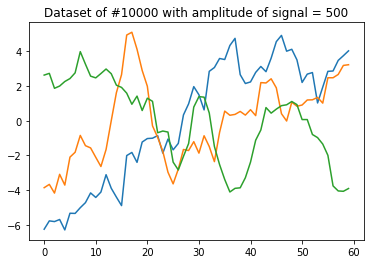

In [3]:
x_train,y_train,x_val,y_val,N_val,L,n_class = import_data(500)

### Data reshaping

In [4]:
x_train = x_train.reshape(x_train.shape[0], L,1)
x_val = x_val.reshape(x_val.shape[0], L,1)
input_shape = (L,1)

### Fit and weight plot function


The code for the confusion matrix is here

In [5]:
def CNN_fit_and_plot(model, NCONV):
    if NCONV < 50: NCONV = "model_number = " + str(NCONV)
    else: NCONV = "Amplitude of the signal = " + str(NCONV) #we use NCONV to define the new amplitude question 4    
    print(model.summary())
    batch_size = 250
    epochs = 50

    fit = model.fit(x_train, y_train, 
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data = (x_val, y_val),
                   verbose = 0, shuffle= True)
    
    pred = model.predict(x_val)                 
    print("DONE!")
    cm = metrics.confusion_matrix(y_val.argmax(axis=1),pred.argmax(axis=1))
    cm=cm/np.sum(np.sum(cm))
    fig, ax = plt.subplots(1)
    im = ax.imshow(cm, cmap = 'viridis')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("rate", rotation=-90, va="bottom")

    labels = ["absent", "positive", "negative"]
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    #plot accuracy, train and validation
    ofig, oax = plt.subplots(1,2,figsize = (15,5))
    fig.suptitle(NCONV)
    for obs in('accuracy', 'loss'):
        l=0
        if obs == 'loss': l=1
        
        oax[l].plot(fit.history[obs], 'r',
                label = obs+' of training data')
        oax[l].plot(fit.history['val_'+obs], 'b--',
                label = obs+' of validation data')
        oax[l].set_title(obs)
        oax[l].set_ylabel(obs)
        oax[l].set_xlabel('Epoch')
        oax[l].legend()
        oax[l].set_ylim(0)


    c = ['k', 'r', 'y' ,'b', 'm']
    def plot_w(w,w0):
        lw=len(w)+1
        figw, axw =plt.subplots(1,1,figsize=(15,5))
        figw.suptitle(NCONV +"-> weight : " +(w0))
        for i in range(len(w)):
            axw.plot(w[i][0], c[i], label = str(i))
            axw.set_ylabel('weight')
            axw.set_xlabel('index')
        axw.legend()
     
    if 0<len(model.layers):
        w0 = model.layers[0].get_weights()[0]  # weight
        w01 = model.layers[0].get_weights()[1] #bias
        w0T = w0.T
        plot_w(w0T,'w0t')
    if 0<len(model.layers[2].get_weights()):
        w02=model.layers[2].get_weights()[0]
        w02_t=w02.T
        plot_w(w02_t,'w02_t')
    #print('w0T=', w0T)
    #print('w01=', w01)
    #print(len(w0))
    #print(len(w0T))
    

 
    fig3,ax3=plt.subplots(1)
    ax3.plot(w01, 'r', label = str(i))
    ax3.set_ylabel('bias of layer 0')
    ax3.set_xlabel('filter nr')
    

### Convolutional NN: Different architectures

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_1 (Average (None, 10, 5)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
________________________________________________

DONE!


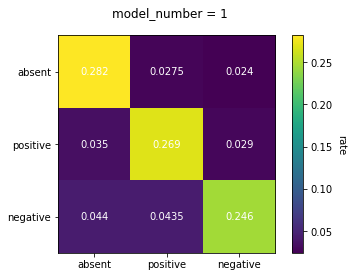

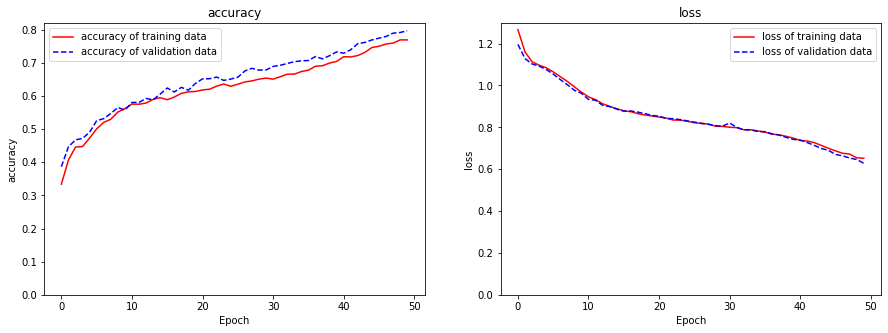

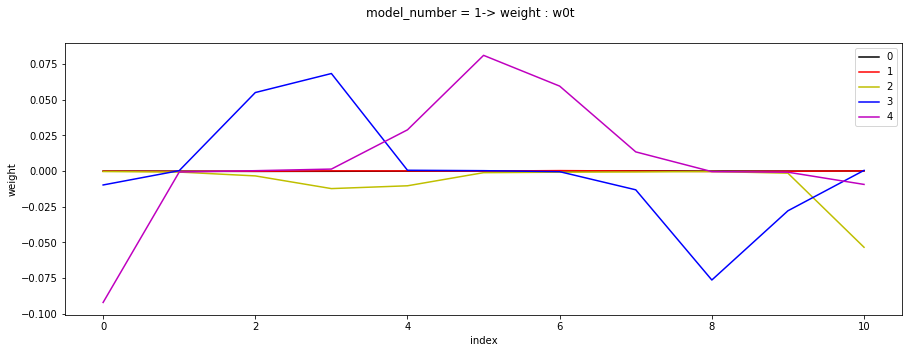

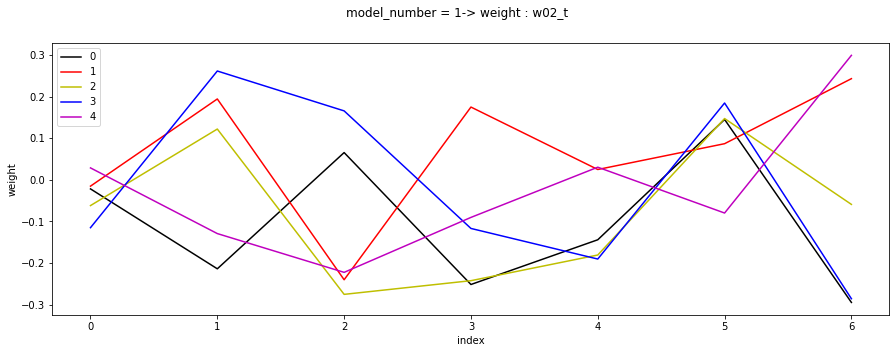

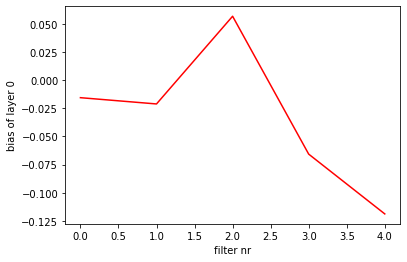

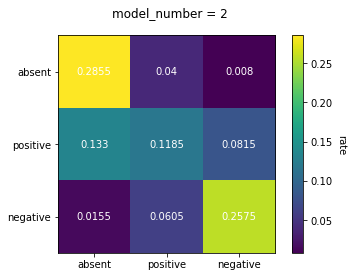

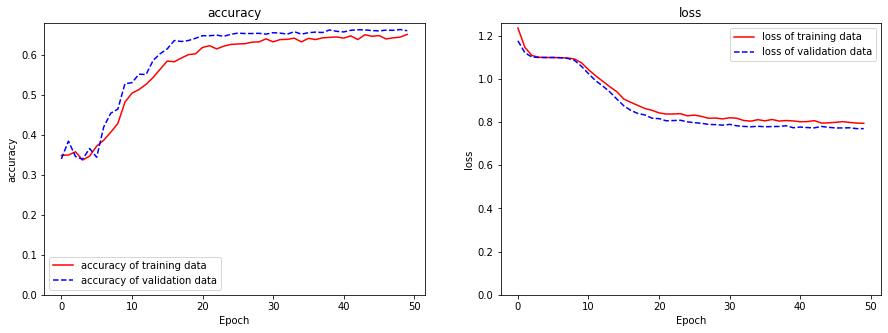

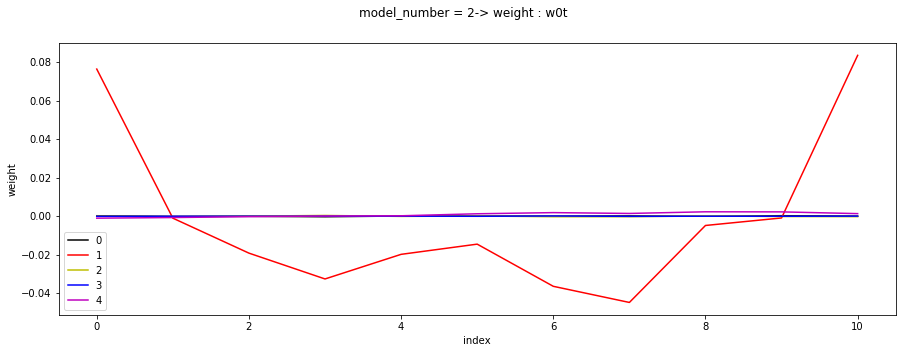

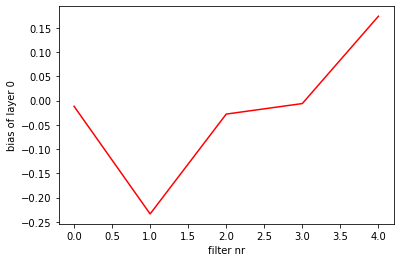

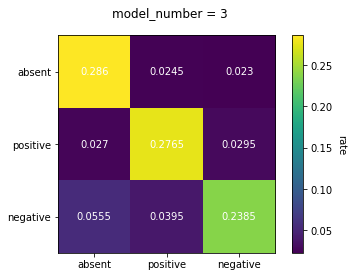

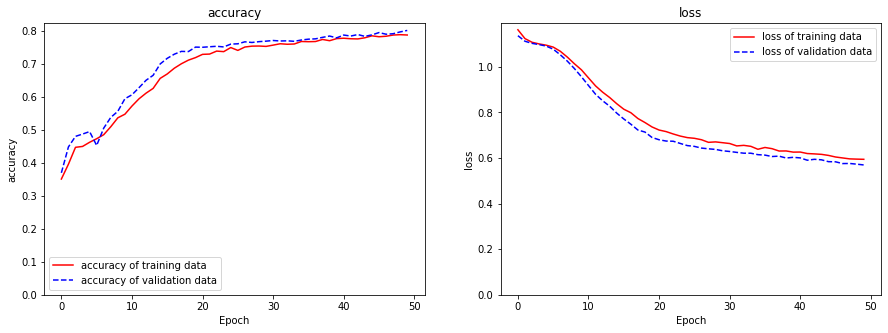

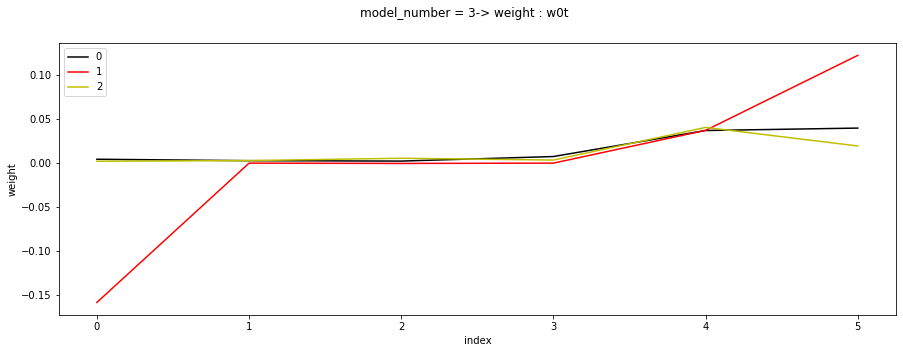

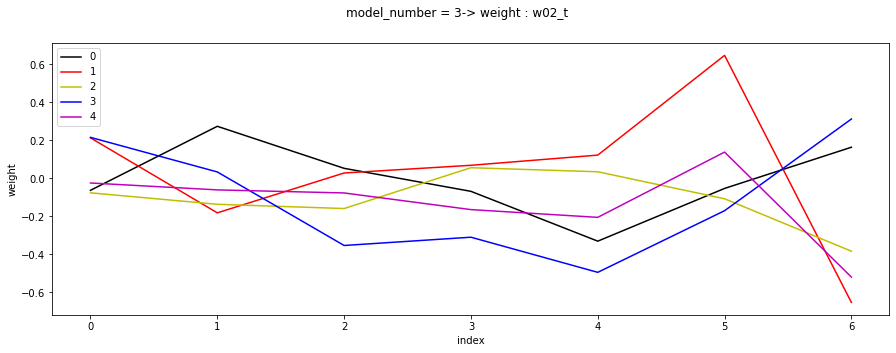

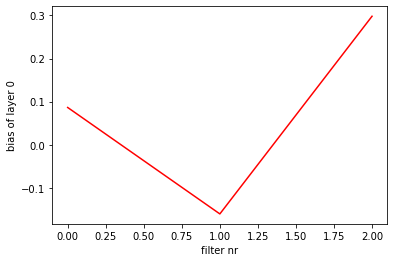

In [6]:
from keras import initializers

reg = keras.regularizers.l1(0.1) #LASSO
ini = keras.initializers.RandomNormal(mean = 0, stddev = 0.05, seed = 12345)
for i in range(1,4):
    NCONV = i
    model = Sequential()
    # 2 Conv1D, 1 Dense, 483 parameters
    if(NCONV == 1):
        model.add(Conv1D(filters = 5, kernel_size=11,
                        kernel_regularizer = reg,
                        kernel_initializer = ini,
                        activation='relu',
                        input_shape = input_shape))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters = 5, kernel_size=7,activation='relu'))
        model.add(Flatten())
        model.add(Dense(10, activation = 'relu'))
        model.add(Dropout(0.2))

    # 1 Conv1D, 2 Dense layers, 600 parameters
    if(NCONV == 2):
        model.add(Conv1D(filters = 5, kernel_size=11,
                        kernel_regularizer = reg,
                        kernel_initializer = ini,
                        activation='relu',
                        input_shape = input_shape))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(9, activation = 'relu'))
        model.add(Dense(6, activation = 'relu'))
        model.add(Dropout(0.2))

    # same as NCONV 1, but the filter lenght is reduced, 508 parameters
    #Better performance than NCONV 1
    if(NCONV == 3):
        model.add(Conv1D(filters = 3, kernel_size=6,
                        kernel_regularizer = reg,
                        kernel_initializer = ini,
                        activation='relu',
                        input_shape = input_shape))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters = 5, kernel_size=7,activation='relu'))
        model.add(Flatten())
        model.add(Dense(10, activation = 'relu'))
        model.add(Dropout(0.2))

    model.add(Dense(n_class, activation= 'softmax'))

    print(model.summary())
    from keras import optimizers
    #opt = optimizers.SGD(lr=0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
    #opt = optimizers.RMSprop()
    opt = optimizers.Adam()
    #opt = optimizers.Nadam()

    #model: categorical 
    model.compile(loss = keras.losses.categorical_crossentropy,
                 optimizer = opt, metrics = ['accuracy'])
    CNN_fit_and_plot(model,NCONV)
    
    NCONV += 1

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from sklearn.model_selection import GridSearchCV





def new_model(_lambda,_which):
    print("which = ", _which, "lambda = ", _lambda)
    if(_which=="l1"):
        reg = keras.regularizers.l1(_lambda) 
    elif(_which=="l2"):
        reg = keras.regularizers.l2(_lambda)
    elif(_which=="l1_l2div"):
        reg = keras.regularizers.l1_l2(_lambda,0.11-_lambda)
    elif(_which=="l1_l2eq"):
        reg = keras.regularizers.l1_l2(_lambda,_lambda)
    
    
    ini = keras.initializers.RandomNormal(mean = 0, stddev = 0.05, seed = 12345)
    model = Sequential()
    model.add(Conv1D(filters = 5, kernel_size=11,
                        kernel_regularizer = reg,
                        kernel_initializer = ini,
                        activation='relu',
                        input_shape = input_shape))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters = 5, kernel_size=7,activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation= 'softmax'))
    model.compile(loss = keras.losses.categorical_crossentropy,
                     optimizer = 'adam', metrics = ['accuracy'])
    return(model)

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=new_model, 
                        epochs=20, 
                        batch_size=20, 
                        verbose=1)

# list of allowed optional arguments for the optimizer, see `compile_model()`
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# optimizer = ['SGD', 'RMSprop','Adam', 'Adamax', 'Nadam']
parameters = {'_lambda':[0.01,0.025,0.05,0.1], "_which":["l1","l2","l1_l2div","l1_l2eq"]}

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=parameters, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)


which =  l1 lambda =  0.01
Epoch 1/20
6000/6000 [==============================] - 1s 118us/step - loss: 1.1139 - accuracy: 0.3668
Epoch 2/20
6000/6000 [==============================] - 0s 74us/step - loss: 1.0495 - accuracy: 0.4735
Epoch 3/20
6000/6000 [==============================] - 0s 72us/step - loss: 0.8843 - accuracy: 0.6168
Epoch 4/20
6000/6000 [==============================] - 0s 74us/step - loss: 0.7536 - accuracy: 0.6950
Epoch 5/20
6000/6000 [==============================] - 0s 82us/step - loss: 0.6945 - accuracy: 0.7187
Epoch 6/20
6000/6000 [==============================] - 1s 107us/step - loss: 0.6617 - accuracy: 0.7332
Epoch 7/20
6000/6000 [==============================] - 1s 99us/step - loss: 0.6307 - accuracy: 0.7610
Epoch 8/20
6000/6000 [==============================] - 0s 77us/step - loss: 0.6165 - accuracy: 0.7693
Epoch 9/20
6000/6000 [==============================] - 0s 76us/step - loss: 0.5974 - accuracy: 0.7827
Epoch 10/20
6000/6000 [=====================

6000/6000 [==============================] - 0s 77us/step - loss: 0.4880 - accuracy: 0.8248
Epoch 18/20
6000/6000 [==============================] - 0s 82us/step - loss: 0.4806 - accuracy: 0.8232
Epoch 19/20
6000/6000 [==============================] - 0s 80us/step - loss: 0.4804 - accuracy: 0.8302
Epoch 20/20
2000/2000 [==============================] - 0s 76us/step
which =  l2 lambda =  0.01
Epoch 1/20
6000/6000 [==============================] - 1s 126us/step - loss: 1.0688 - accuracy: 0.3953
Epoch 2/20
6000/6000 [==============================] - 0s 81us/step - loss: 0.9947 - accuracy: 0.4750
Epoch 3/20
6000/6000 [==============================] - 1s 84us/step - loss: 0.9240 - accuracy: 0.5405
Epoch 4/20
6000/6000 [==============================] - 1s 86us/step - loss: 0.8666 - accuracy: 0.5835
Epoch 5/20
6000/6000 [==============================] - 0s 81us/step - loss: 0.8327 - accuracy: 0.6020
Epoch 6/20
6000/6000 [==============================] - 1s 87us/step - loss: 0.7880 - a

6000/6000 [==============================] - 0s 81us/step - loss: 0.5501 - accuracy: 0.7932
Epoch 13/20
6000/6000 [==============================] - 0s 81us/step - loss: 0.5429 - accuracy: 0.7977
Epoch 14/20
6000/6000 [==============================] - 0s 80us/step - loss: 0.5341 - accuracy: 0.7992
Epoch 15/20
6000/6000 [==============================] - 0s 81us/step - loss: 0.5179 - accuracy: 0.8057
Epoch 16/20
6000/6000 [==============================] - 0s 80us/step - loss: 0.5144 - accuracy: 0.8090
Epoch 17/20
6000/6000 [==============================] - 0s 81us/step - loss: 0.5142 - accuracy: 0.8097
Epoch 18/20
6000/6000 [==============================] - 0s 81us/step - loss: 0.4986 - accuracy: 0.8160
Epoch 19/20
6000/6000 [==============================] - 0s 81us/step - loss: 0.4946 - accuracy: 0.8217
Epoch 20/20
2000/2000 [==============================] - 0s 100us/step
which =  l1_l2div lambda =  0.01
Epoch 1/20
6000/6000 [==============================] - 1s 129us/step - loss

6000/6000 [==============================] - 1s 87us/step - loss: 0.7106 - accuracy: 0.7315
Epoch 8/20
6000/6000 [==============================] - 1s 88us/step - loss: 0.6913 - accuracy: 0.7410
Epoch 9/20
6000/6000 [==============================] - 1s 87us/step - loss: 0.6671 - accuracy: 0.7498
Epoch 10/20
6000/6000 [==============================] - 1s 87us/step - loss: 0.6641 - accuracy: 0.7537
Epoch 11/20
6000/6000 [==============================] - 1s 87us/step - loss: 0.6340 - accuracy: 0.7653
Epoch 12/20
6000/6000 [==============================] - 1s 87us/step - loss: 0.6297 - accuracy: 0.7645
Epoch 13/20
6000/6000 [==============================] - 1s 87us/step - loss: 0.6194 - accuracy: 0.7735
Epoch 14/20
6000/6000 [==============================] - 1s 88us/step - loss: 0.6057 - accuracy: 0.7795
Epoch 15/20
6000/6000 [==============================] - 1s 87us/step - loss: 0.6100 - accuracy: 0.7750
Epoch 16/20
6000/6000 [==============================] - 1s 88us/step - loss: 

6000/6000 [==============================] - 1s 104us/step - loss: 1.0342 - accuracy: 0.4882
Epoch 3/20
6000/6000 [==============================] - 1s 107us/step - loss: 0.9183 - accuracy: 0.5983
Epoch 4/20
6000/6000 [==============================] - 1s 118us/step - loss: 0.8072 - accuracy: 0.6628
Epoch 5/20
6000/6000 [==============================] - 1s 100us/step - loss: 0.7247 - accuracy: 0.7092
Epoch 6/20
6000/6000 [==============================] - 1s 101us/step - loss: 0.6629 - accuracy: 0.7467
Epoch 7/20
6000/6000 [==============================] - 1s 104us/step - loss: 0.6302 - accuracy: 0.7625
Epoch 8/20
6000/6000 [==============================] - 1s 122us/step - loss: 0.5950 - accuracy: 0.7823
Epoch 9/20
6000/6000 [==============================] - 1s 124us/step - loss: 0.5716 - accuracy: 0.7953
Epoch 10/20
6000/6000 [==============================] - 1s 140us/step - loss: 0.5502 - accuracy: 0.8005
Epoch 11/20
6000/6000 [==============================] - 1s 114us/step - l

Epoch 18/20
6000/6000 [==============================] - 1s 160us/step - loss: 0.5031 - accuracy: 0.8333
Epoch 19/20
6000/6000 [==============================] - 1s 139us/step - loss: 0.4972 - accuracy: 0.8377
Epoch 20/20
2000/2000 [==============================] - 0s 217us/step
which =  l1 lambda =  0.025
Epoch 1/20
6000/6000 [==============================] - 1s 248us/step - loss: 1.1071 - accuracy: 0.4013
Epoch 2/20
6000/6000 [==============================] - 1s 120us/step - loss: 0.9703 - accuracy: 0.5582
Epoch 3/20
6000/6000 [==============================] - 1s 135us/step - loss: 0.8063 - accuracy: 0.6715
Epoch 4/20
6000/6000 [==============================] - 1s 147us/step - loss: 0.7278 - accuracy: 0.7173
Epoch 5/20
6000/6000 [==============================] - 1s 136us/step - loss: 0.6921 - accuracy: 0.7408
Epoch 6/20
6000/6000 [==============================] - 1s 156us/step - loss: 0.6598 - accuracy: 0.7585
Epoch 7/20
6000/6000 [==============================] - 1s 147us/st

6000/6000 [==============================] - 1s 121us/step - loss: 0.4291 - accuracy: 0.8500
Epoch 14/20
6000/6000 [==============================] - 1s 124us/step - loss: 0.4131 - accuracy: 0.8543
Epoch 15/20
6000/6000 [==============================] - 1s 119us/step - loss: 0.4079 - accuracy: 0.8582
Epoch 16/20
6000/6000 [==============================] - 1s 122us/step - loss: 0.4061 - accuracy: 0.8588
Epoch 17/20
6000/6000 [==============================] - 1s 124us/step - loss: 0.3964 - accuracy: 0.8640
Epoch 18/20
6000/6000 [==============================] - 1s 128us/step - loss: 0.3957 - accuracy: 0.8650
Epoch 19/20
6000/6000 [==============================] - 1s 121us/step - loss: 0.3940 - accuracy: 0.8607
Epoch 20/20
2000/2000 [==============================] - 0s 219us/step
which =  l2 lambda =  0.025
Epoch 1/20
6000/6000 [==============================] - 1s 208us/step - loss: 1.0760 - accuracy: 0.3890
Epoch 2/20
6000/6000 [==============================] - 1s 126us/step - lo

Epoch 8/20
6000/6000 [==============================] - 1s 141us/step - loss: 0.6837 - accuracy: 0.7443
Epoch 9/20
6000/6000 [==============================] - 1s 139us/step - loss: 0.6604 - accuracy: 0.7592
Epoch 10/20
6000/6000 [==============================] - 1s 133us/step - loss: 0.6373 - accuracy: 0.7698
Epoch 11/20
6000/6000 [==============================] - 1s 131us/step - loss: 0.6201 - accuracy: 0.7782
Epoch 12/20
6000/6000 [==============================] - 1s 127us/step - loss: 0.6071 - accuracy: 0.7808
Epoch 13/20
6000/6000 [==============================] - 1s 128us/step - loss: 0.5918 - accuracy: 0.7832
Epoch 14/20
6000/6000 [==============================] - 1s 132us/step - loss: 0.5776 - accuracy: 0.7992
Epoch 15/20
6000/6000 [==============================] - 1s 135us/step - loss: 0.5722 - accuracy: 0.7968
Epoch 16/20
6000/6000 [==============================] - 1s 126us/step - loss: 0.5718 - accuracy: 0.7923
Epoch 17/20
6000/6000 [==============================] - 

6000/6000 [==============================] - 1s 135us/step - loss: 1.0662 - accuracy: 0.4492
Epoch 3/20
6000/6000 [==============================] - 1s 134us/step - loss: 0.9882 - accuracy: 0.5448
Epoch 4/20
6000/6000 [==============================] - 1s 136us/step - loss: 0.8975 - accuracy: 0.5953
Epoch 5/20
6000/6000 [==============================] - 1s 138us/step - loss: 0.8560 - accuracy: 0.6273
Epoch 6/20
6000/6000 [==============================] - 1s 139us/step - loss: 0.8279 - accuracy: 0.6367
Epoch 7/20
6000/6000 [==============================] - 1s 138us/step - loss: 0.8121 - accuracy: 0.6460
Epoch 8/20
6000/6000 [==============================] - 1s 139us/step - loss: 0.7936 - accuracy: 0.6547
Epoch 9/20
6000/6000 [==============================] - 1s 140us/step - loss: 0.7785 - accuracy: 0.6732
Epoch 10/20
6000/6000 [==============================] - 1s 140us/step - loss: 0.7646 - accuracy: 0.6823
Epoch 11/20
6000/6000 [==============================] - 1s 138us/step - l

Epoch 18/20
6000/6000 [==============================] - 1s 138us/step - loss: 0.5470 - accuracy: 0.8135
Epoch 19/20
6000/6000 [==============================] - 1s 138us/step - loss: 0.5439 - accuracy: 0.8188
Epoch 20/20
2000/2000 [==============================] - 1s 314us/step
which =  l1 lambda =  0.05
Epoch 1/20
6000/6000 [==============================] - 1s 241us/step - loss: 1.1234 - accuracy: 0.3580
Epoch 2/20
6000/6000 [==============================] - 1s 141us/step - loss: 1.0807 - accuracy: 0.4237
Epoch 3/20
6000/6000 [==============================] - 1s 139us/step - loss: 1.0146 - accuracy: 0.5347
Epoch 4/20
6000/6000 [==============================] - 1s 139us/step - loss: 0.9136 - accuracy: 0.6093
Epoch 5/20
6000/6000 [==============================] - 1s 139us/step - loss: 0.8468 - accuracy: 0.6558
Epoch 6/20
6000/6000 [==============================] - 1s 142us/step - loss: 0.7930 - accuracy: 0.6970
Epoch 7/20
6000/6000 [==============================] - 1s 141us/ste

6000/6000 [==============================] - 1s 177us/step - loss: 0.4874 - accuracy: 0.8282
Epoch 14/20
6000/6000 [==============================] - 1s 174us/step - loss: 0.4713 - accuracy: 0.8335
Epoch 15/20
6000/6000 [==============================] - 1s 174us/step - loss: 0.4643 - accuracy: 0.8348
Epoch 16/20
6000/6000 [==============================] - 1s 176us/step - loss: 0.4581 - accuracy: 0.8358
Epoch 17/20
6000/6000 [==============================] - 1s 174us/step - loss: 0.4498 - accuracy: 0.8438
Epoch 18/20
6000/6000 [==============================] - 1s 173us/step - loss: 0.4479 - accuracy: 0.8425
Epoch 19/20
6000/6000 [==============================] - 1s 173us/step - loss: 0.4371 - accuracy: 0.8498
Epoch 20/20
2000/2000 [==============================] - 1s 369us/step
which =  l2 lambda =  0.05
Epoch 1/20
6000/6000 [==============================] - 2s 306us/step - loss: 1.0973 - accuracy: 0.3593
Epoch 2/20
6000/6000 [==============================] - 1s 185us/step - los

6000/6000 [==============================] - 1s 185us/step - loss: 0.8713 - accuracy: 0.6093
Epoch 9/20
6000/6000 [==============================] - 1s 181us/step - loss: 0.8634 - accuracy: 0.6115
Epoch 10/20
6000/6000 [==============================] - 1s 183us/step - loss: 0.8578 - accuracy: 0.6165
Epoch 11/20
6000/6000 [==============================] - 1s 181us/step - loss: 0.8455 - accuracy: 0.6228
Epoch 12/20
6000/6000 [==============================] - 1s 182us/step - loss: 0.8390 - accuracy: 0.6152
Epoch 13/20
6000/6000 [==============================] - 1s 185us/step - loss: 0.8352 - accuracy: 0.6308
Epoch 14/20
6000/6000 [==============================] - 1s 184us/step - loss: 0.8156 - accuracy: 0.6375
Epoch 15/20
6000/6000 [==============================] - 1s 183us/step - loss: 0.8141 - accuracy: 0.6443
Epoch 16/20
6000/6000 [==============================] - 1s 183us/step - loss: 0.8018 - accuracy: 0.6537
Epoch 17/20
6000/6000 [==============================] - 1s 182us/st

Epoch 3/20
6000/6000 [==============================] - 1s 216us/step - loss: 0.9212 - accuracy: 0.5750
Epoch 4/20
6000/6000 [==============================] - 1s 227us/step - loss: 0.8469 - accuracy: 0.6230
Epoch 5/20
6000/6000 [==============================] - 1s 198us/step - loss: 0.8040 - accuracy: 0.6675
Epoch 6/20
6000/6000 [==============================] - 1s 211us/step - loss: 0.7634 - accuracy: 0.6950
Epoch 7/20
6000/6000 [==============================] - 1s 195us/step - loss: 0.7321 - accuracy: 0.7227
Epoch 8/20
6000/6000 [==============================] - 1s 194us/step - loss: 0.6965 - accuracy: 0.7448
Epoch 9/20
6000/6000 [==============================] - 1s 194us/step - loss: 0.6684 - accuracy: 0.7598
Epoch 10/20
6000/6000 [==============================] - 1s 194us/step - loss: 0.6600 - accuracy: 0.7628
Epoch 11/20
6000/6000 [==============================] - 1s 194us/step - loss: 0.6418 - accuracy: 0.7720
Epoch 12/20
6000/6000 [==============================] - 1s 19

6000/6000 [==============================] - 1s 192us/step - loss: 0.5984 - accuracy: 0.8002
Epoch 19/20
6000/6000 [==============================] - 1s 191us/step - loss: 0.5882 - accuracy: 0.8008
Epoch 20/20
2000/2000 [==============================] - 1s 458us/step
which =  l1 lambda =  0.1
Epoch 1/20
6000/6000 [==============================] - 2s 340us/step - loss: 1.1358 - accuracy: 0.3792
Epoch 2/20
6000/6000 [==============================] - 1s 196us/step - loss: 1.0863 - accuracy: 0.4353
Epoch 3/20
6000/6000 [==============================] - 1s 197us/step - loss: 1.0362 - accuracy: 0.5053
Epoch 4/20
6000/6000 [==============================] - 1s 196us/step - loss: 0.9930 - accuracy: 0.5453
Epoch 5/20
6000/6000 [==============================] - 1s 196us/step - loss: 0.9536 - accuracy: 0.5757
Epoch 6/20
6000/6000 [==============================] - 1s 196us/step - loss: 0.9364 - accuracy: 0.5757
Epoch 7/20
6000/6000 [==============================] - 1s 194us/step - loss: 0.9

6000/6000 [==============================] - 1s 204us/step - loss: 0.5102 - accuracy: 0.8195
Epoch 14/20
6000/6000 [==============================] - 1s 201us/step - loss: 0.5052 - accuracy: 0.8213
Epoch 15/20
6000/6000 [==============================] - 1s 201us/step - loss: 0.4998 - accuracy: 0.8258
Epoch 16/20
6000/6000 [==============================] - 1s 200us/step - loss: 0.4966 - accuracy: 0.8270
Epoch 17/20
6000/6000 [==============================] - 1s 203us/step - loss: 0.4893 - accuracy: 0.8290
Epoch 18/20
6000/6000 [==============================] - 1s 204us/step - loss: 0.4870 - accuracy: 0.8287
Epoch 19/20
6000/6000 [==============================] - 1s 206us/step - loss: 0.4788 - accuracy: 0.8327
Epoch 20/20
2000/2000 [==============================] - 1s 497us/step
which =  l2 lambda =  0.1
Epoch 1/20
6000/6000 [==============================] - 2s 355us/step - loss: 1.0929 - accuracy: 0.3880
Epoch 2/20
6000/6000 [==============================] - 1s 203us/step - loss

6000/6000 [==============================] - 1s 208us/step - loss: 1.0993 - accuracy: 0.3210
Epoch 9/20
6000/6000 [==============================] - 1s 211us/step - loss: 1.0995 - accuracy: 0.3248
Epoch 10/20
6000/6000 [==============================] - 1s 209us/step - loss: 1.0993 - accuracy: 0.3285
Epoch 11/20
6000/6000 [==============================] - 1s 209us/step - loss: 1.0994 - accuracy: 0.3285
Epoch 12/20
6000/6000 [==============================] - 1s 208us/step - loss: 1.0992 - accuracy: 0.3393
Epoch 13/20
6000/6000 [==============================] - 1s 208us/step - loss: 1.0994 - accuracy: 0.3350
Epoch 14/20
6000/6000 [==============================] - 1s 208us/step - loss: 1.0996 - accuracy: 0.3255
Epoch 15/20
6000/6000 [==============================] - 1s 210us/step - loss: 1.0995 - accuracy: 0.3205
Epoch 16/20
6000/6000 [==============================] - 1s 208us/step - loss: 1.0994 - accuracy: 0.3245
Epoch 17/20
6000/6000 [==============================] - 1s 208us/st

Epoch 3/20
6000/6000 [==============================] - 1s 216us/step - loss: 1.0326 - accuracy: 0.5032
Epoch 4/20
6000/6000 [==============================] - 1s 219us/step - loss: 0.9632 - accuracy: 0.5763
Epoch 5/20
6000/6000 [==============================] - 1s 218us/step - loss: 0.9134 - accuracy: 0.6070
Epoch 6/20
6000/6000 [==============================] - 1s 216us/step - loss: 0.8766 - accuracy: 0.6327
Epoch 7/20
6000/6000 [==============================] - 1s 214us/step - loss: 0.8446 - accuracy: 0.6590
Epoch 8/20
6000/6000 [==============================] - 1s 215us/step - loss: 0.8113 - accuracy: 0.6755
Epoch 9/20
6000/6000 [==============================] - 1s 215us/step - loss: 0.7975 - accuracy: 0.6922
Epoch 10/20
6000/6000 [==============================] - 1s 217us/step - loss: 0.7629 - accuracy: 0.7102
Epoch 11/20
6000/6000 [==============================] - 1s 217us/step - loss: 0.7377 - accuracy: 0.7322
Epoch 12/20
6000/6000 [==============================] - 1s 21

6000/6000 [==============================] - 1s 224us/step - loss: 1.0994 - accuracy: 0.3152
Epoch 19/20
6000/6000 [==============================] - 1s 232us/step - loss: 1.0994 - accuracy: 0.3318
Epoch 20/20
2000/2000 [==============================] - 1s 595us/step
which =  l1_l2eq lambda =  0.01
Epoch 1/20
8000/8000 [==============================] - 3s 366us/step - loss: 1.0766 - accuracy: 0.4397
Epoch 2/20
8000/8000 [==============================] - 2s 223us/step - loss: 0.8793 - accuracy: 0.6246
Epoch 3/20
8000/8000 [==============================] - 2s 223us/step - loss: 0.6808 - accuracy: 0.7341
Epoch 4/20
8000/8000 [==============================] - 2s 222us/step - loss: 0.5946 - accuracy: 0.7809
Epoch 5/20
8000/8000 [==============================] - 2s 223us/step - loss: 0.5552 - accuracy: 0.8009
Epoch 6/20
8000/8000 [==============================] - 2s 224us/step - loss: 0.5236 - accuracy: 0.8164
Epoch 7/20
8000/8000 [==============================] - 2s 222us/step - los

In [8]:
import pandas
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(grid_result.cv_results_.keys())
pd=pandas.DataFrame(grid_result.cv_results_)
pd=pd.sort_values(by=['rank_test_score'])
pd=pd.reset_index()
pd[['param__lambda','param__which', 'mean_test_score', 'rank_test_score']]

Best: 0.853500 using {'_lambda': 0.01, '_which': 'l1_l2eq'}
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param__lambda', 'param__which', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


,param__lambda,param__which,mean_test_score,rank_test_score
0,0.01,l1_l2eq,0.853500,1
1,0.025,l2,0.850000,2
2,0.05,l2,0.849875,3
3,0.025,l1_l2div,0.846750,4
4,0.01,l1,0.841500,5
5,0.01,l1_l2div,0.838250,6
6,0.1,l2,0.834750,7
7,0.01,l2,0.833625,8
8,0.025,l1,0.828750,9
9,0.025,l1_l2eq,0.828750,9


## 1) Is the number of parameters scaling more quickly by adding Dense layers or Conv1D layers?
The number of parameters increases faster when adding Dense layer instead of Convolutional one. This is due to the fact that in Conv1D, for one filter, the weights are shared and patterns are searched locally. 

## 3a) Is any value of lambda good?
The best type of regularization change varying the random seed, and obtains similar scores in different trainings.
Aniway this time the best results are obtained with a regularization of type L1-L2 with both lambdas = 0.01 . 


## 3b) Are there any intermediate values for which the performance is better? 
In our result we saw that different types of regularization are suitable for this problem.
And also emerged that for each type of regularization, althought theres a maxima in the score varying the regularization parameter, this does not differs too much from other results obtaianed with different lambdas.

## 3c) Is there any improvement in the visualization and understanding of the weights in the filters?

We observed an improvement in the visualization of the weights, in the sense that with the L1 regularization chosen in the first part, they had shapes that resembles poorly the signal with respect to the best ones obtained with gridseach.


## 3d) BIAS

Since the regularization is used to avoid overfitting, and the bias term does not contribute to it, there is no need to apply this procedure on bias values.  




which =  l1_l2eq lambda =  0.01
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_69 (Averag (None, 10, 5)             0         
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 4, 5)              180       
_________________________________________________________________
flatten_69 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_69 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_139 (Dense)    

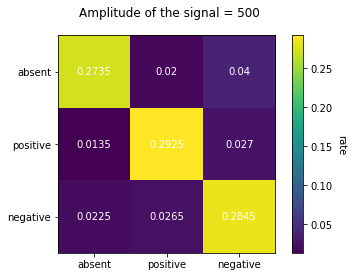

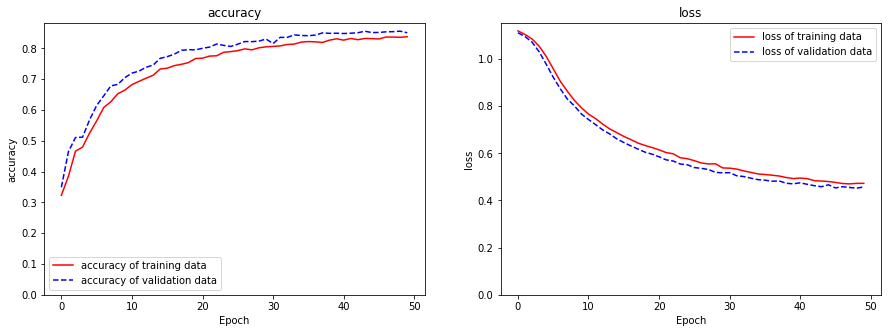

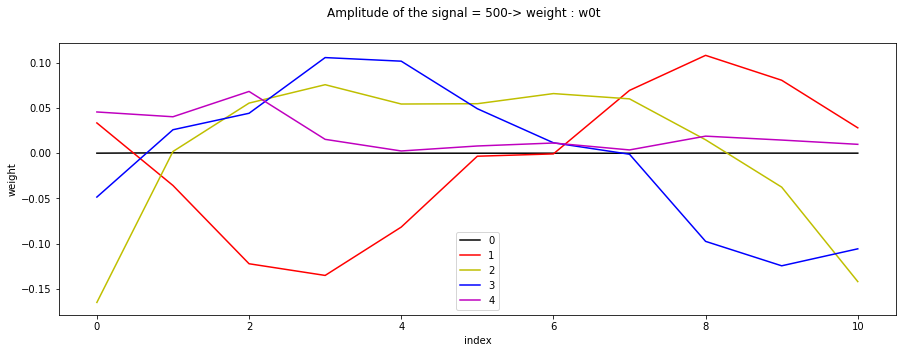

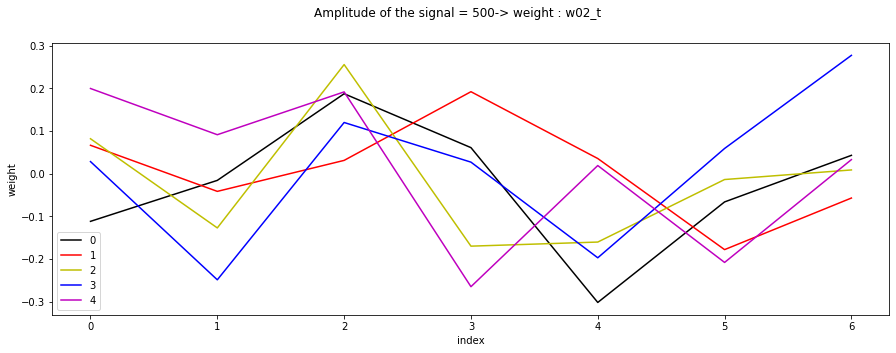

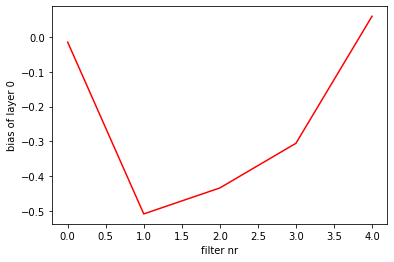

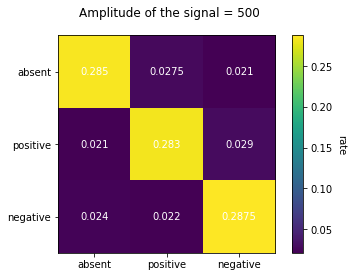

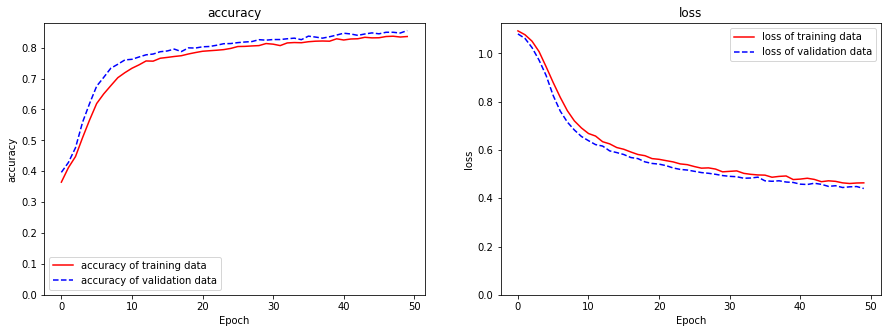

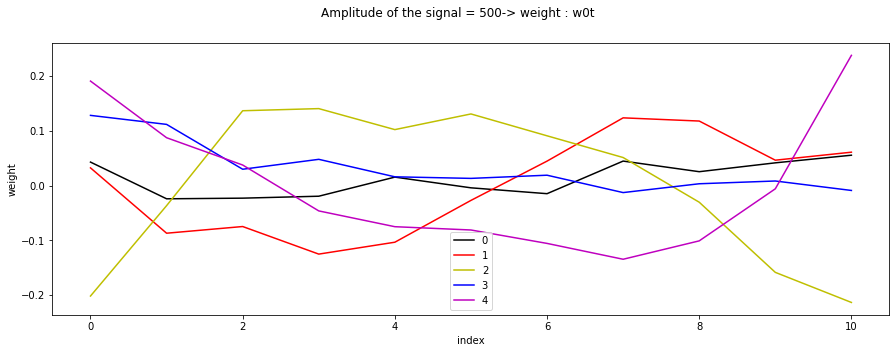

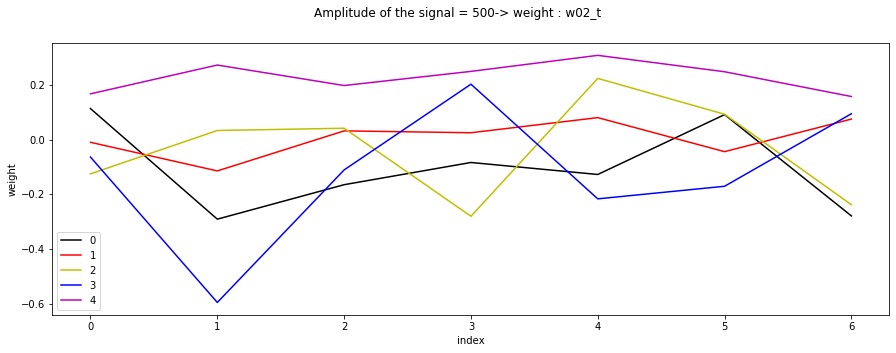

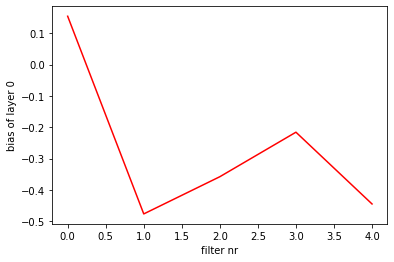

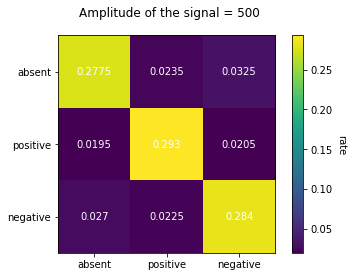

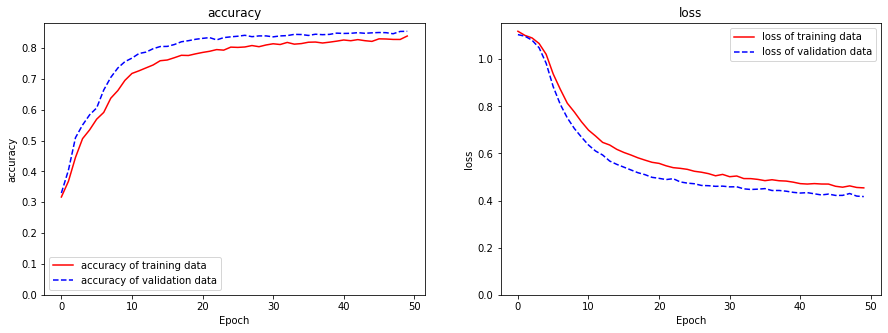

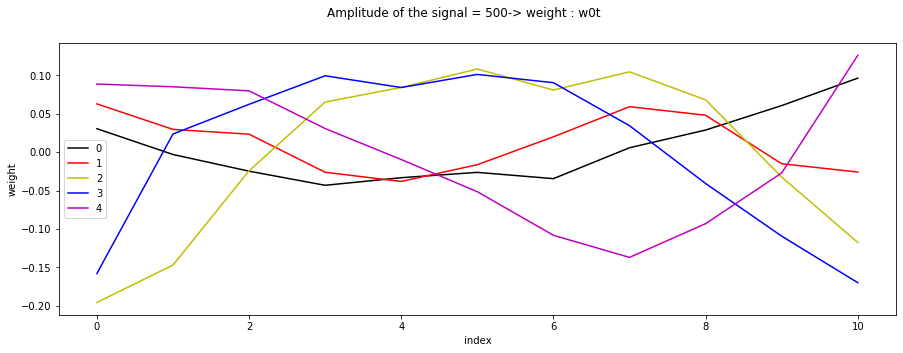

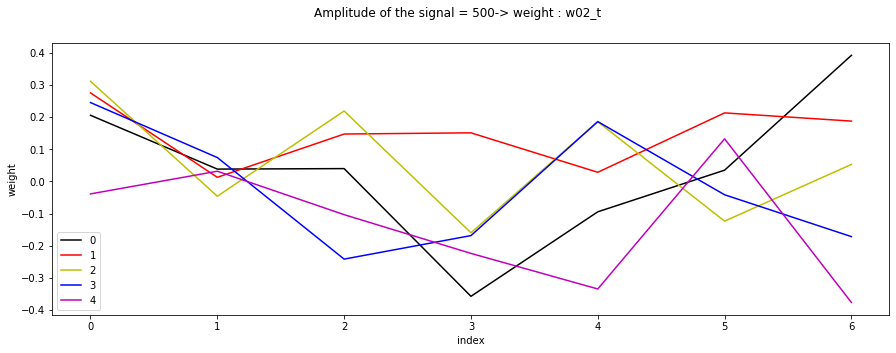

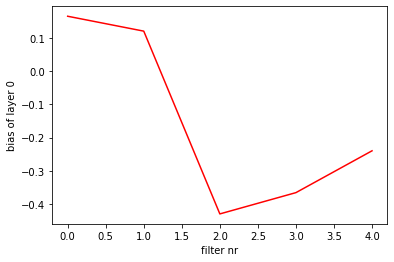

In [9]:

p_l=[[pd.loc[i,'param__lambda'],pd.loc[i,'param__which']] for i in range(3)]

for i in p_l:
    model_=new_model(i[0],i[1])
    model_.compile(loss = keras.losses.categorical_crossentropy,
                 optimizer = optimizers.Adam(), metrics = ['accuracy'])
    CNN_fit_and_plot(model_, 500)


which =  l1_l2eq lambda =  0.01
N_train = 8000 N_val = 2000 L = 60 n_class = 3
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_142 (Conv1D)          (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_72 (Averag (None, 10, 5)             0         
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 4, 5)              180       
_________________________________________________________________
flatten_72 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_72 (Dropout)         (None, 10)                0         
________________________________________

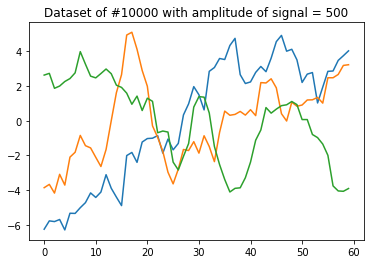

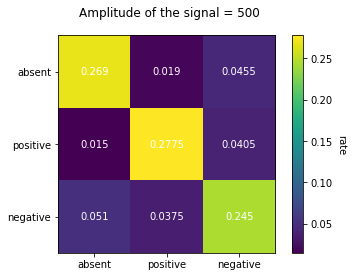

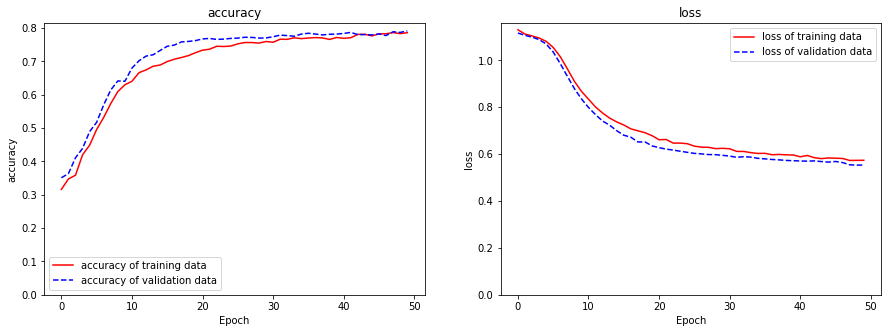

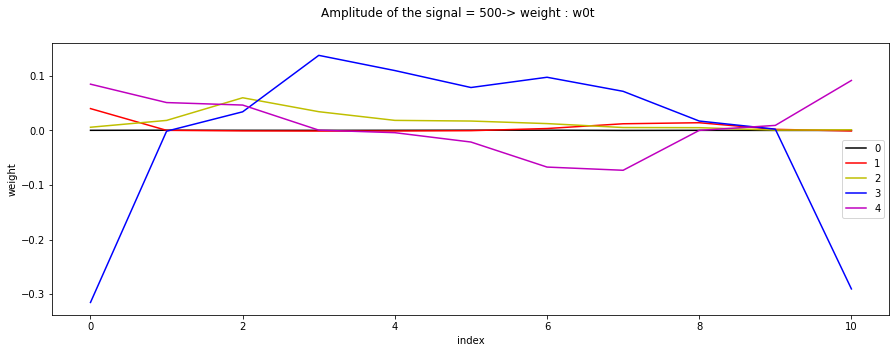

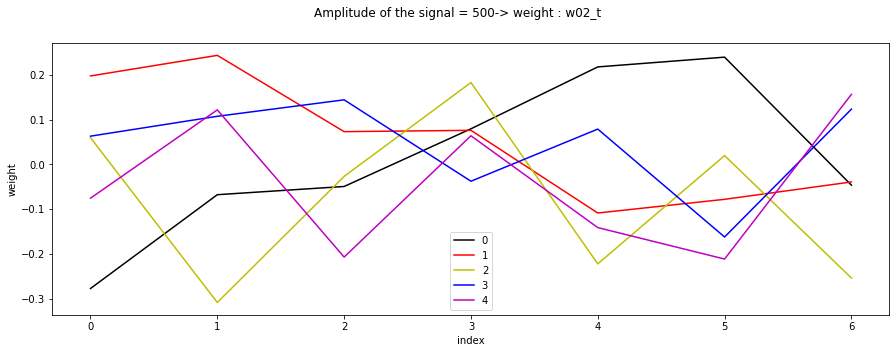

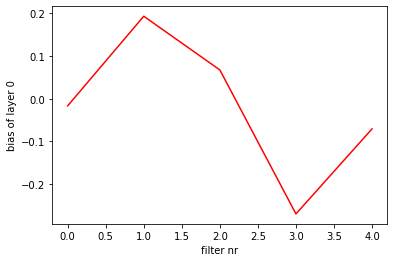

In [10]:
#APPLY MODEL TO 500 AMPLITUDE DATASET"
model_=new_model(grid_result.best_params_["_lambda"],grid_result.best_params_["_which"])
model_.compile(loss = keras.losses.categorical_crossentropy,
                 optimizer = optimizers.Adam(), metrics = ['accuracy'])


x_train,y_train,x_val,y_val,N_val,L, n_class = import_data(500)
x_train = x_train.reshape(x_train.shape[0], L,1)
x_val = x_val.reshape(x_val.shape[0], L,1)
CNN_fit_and_plot(model_, 500)

N_train = 8000 N_val = 2000 L = 60 n_class = 3
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_142 (Conv1D)          (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_72 (Averag (None, 10, 5)             0         
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 4, 5)              180       
_________________________________________________________________
flatten_72 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_72 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_

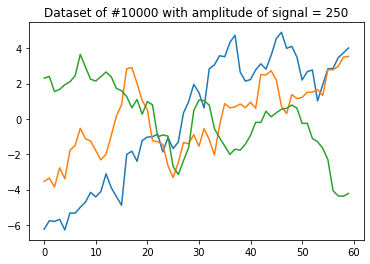

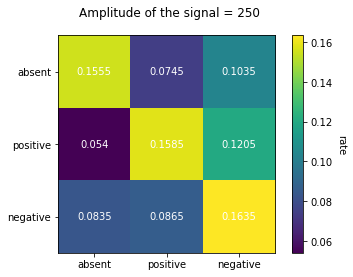

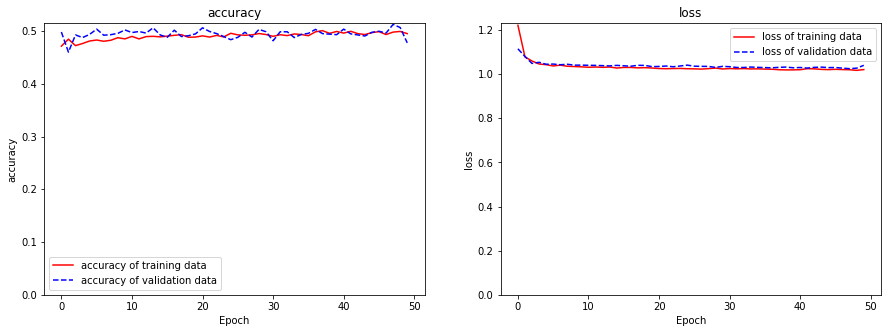

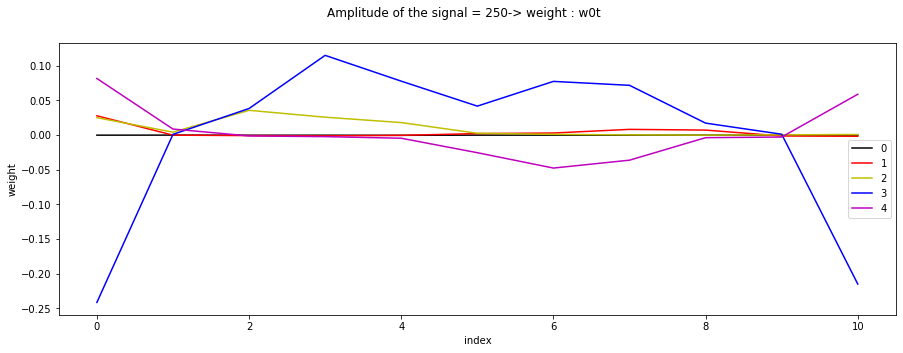

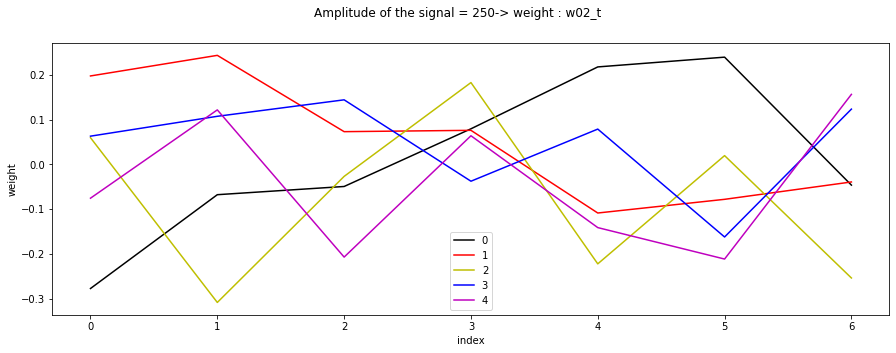

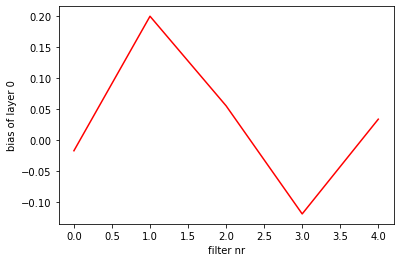

In [11]:
#APPLY MODEL TO 250 AMPLITUDE DATASET"

x_train,y_train,x_val,y_val,N_val,L,n_class = import_data(250)
x_train = x_train.reshape(x_train.shape[0], L,1)
x_val = x_val.reshape(x_val.shape[0], L,1)
input_shape = (L,1)
CNN_fit_and_plot(model_, 250)

N_train = 8000 N_val = 2000 L = 60 n_class = 3
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_142 (Conv1D)          (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_72 (Averag (None, 10, 5)             0         
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 4, 5)              180       
_________________________________________________________________
flatten_72 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_72 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_

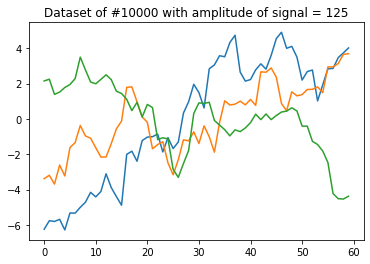

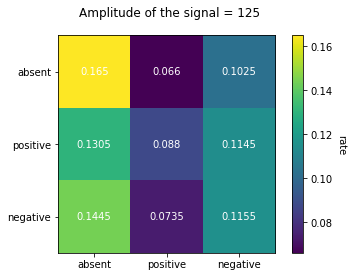

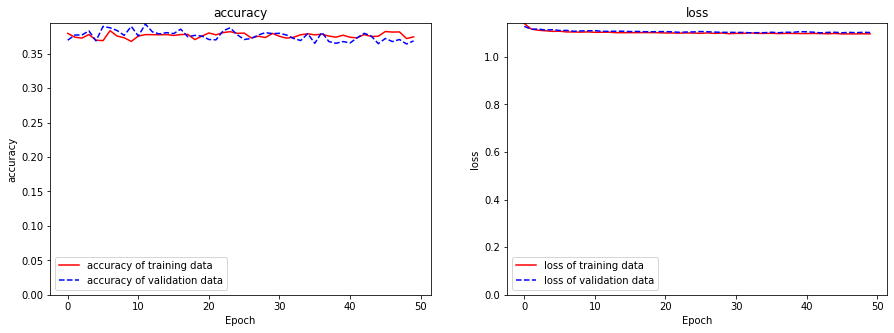

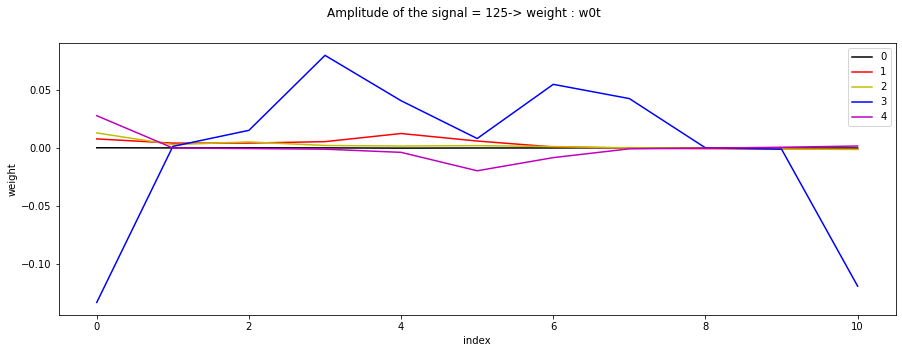

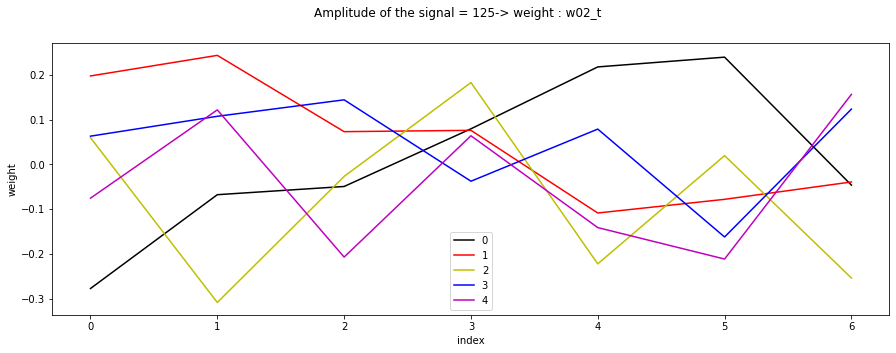

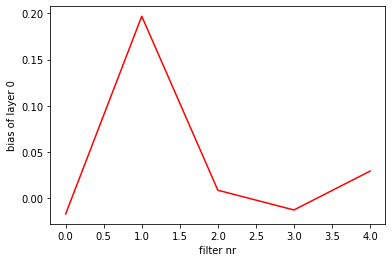

In [12]:
#APPLY MODEL TO 125 AMPLITUDE DATASET"
x_train,y_train,x_val,y_val,N_val,L,n_class = import_data(125)
x_train = x_train.reshape(x_train.shape[0], L,1)
x_val = x_val.reshape(x_val.shape[0], L,1)
input_shape = (L,1)
CNN_fit_and_plot(model_,125)